Gradient Boosting Models (e.g., XGBoost, LightGBM)

Generalized Additive Models (GAM) 

Support Vector Regression (SVR) 

Convolutional Neural Networks (CNN) 

Recurrent Neural Networks (RNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models


In [19]:
import pandas as pd

In [20]:
df = pd.read_csv('./solar_weather_processed.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Energy delta_Wh  196776 non-null  float64
 1   GHI              196776 non-null  float64
 2   temp             196776 non-null  float64
 3   pressure         196776 non-null  float64
 4   humidity         196776 non-null  float64
 5   wind_speed       196776 non-null  float64
 6   rain_1h          196776 non-null  float64
 7   clouds_all       196776 non-null  float64
 8   Year             196776 non-null  int64  
 9   Month_num        196776 non-null  int64  
 10  DayOfYear        196776 non-null  int64  
 11  Minute           196776 non-null  int64  
 12  Hour             196776 non-null  int64  
 13  Season           196776 non-null  int64  
 14  Day              196776 non-null  int64  
 15  Week_cos         196776 non-null  float64
 16  Season_sin       196776 non-null  floa

In [22]:
import sklearn


In [23]:
print(sklearn.__version__)


1.6.1


# Seperate file for model buiding only


In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error


In [25]:
# 6. Define X (features) and y (target)
FEATURES = [col for col in df.columns if col != 'Energy delta_Wh']
X = df[FEATURES]
y = df['Energy delta_Wh']

In [26]:
# 7. Time-based train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

## Models

### XGboost, ligbtGBM

MAE: 0.019789371469873866
RMSE: 0.049970952462288214


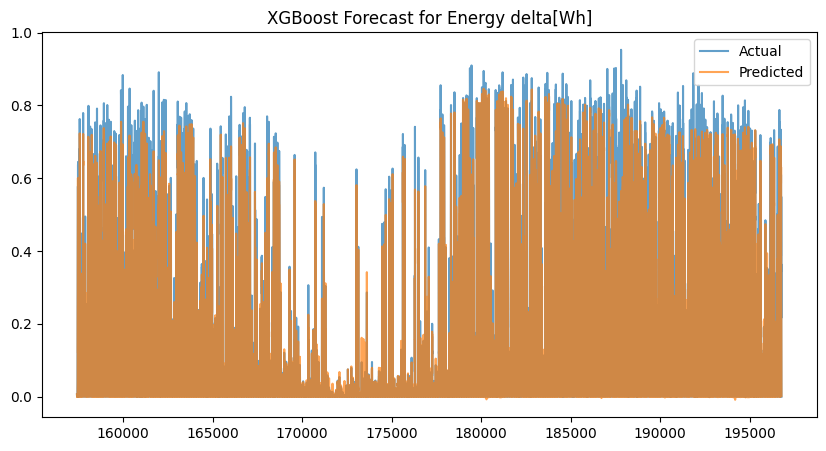

In [27]:
# 8. Train XGBoost
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)], 
          verbose=False)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("XGBoost Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

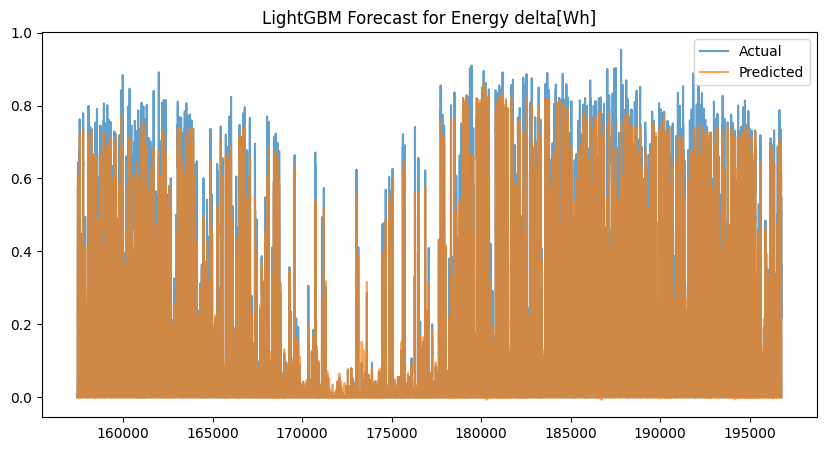

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)])  # Corrected parameter

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2001
[LightGBM] [Info] Number of data points in the train set: 157420, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.112938
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

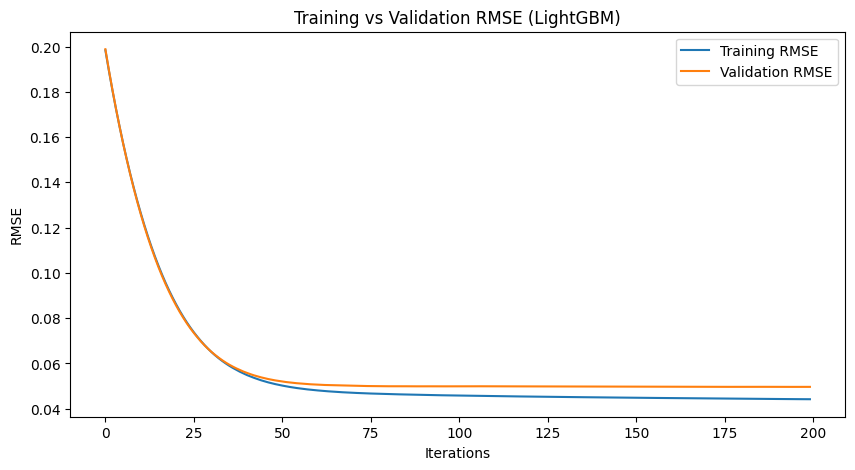

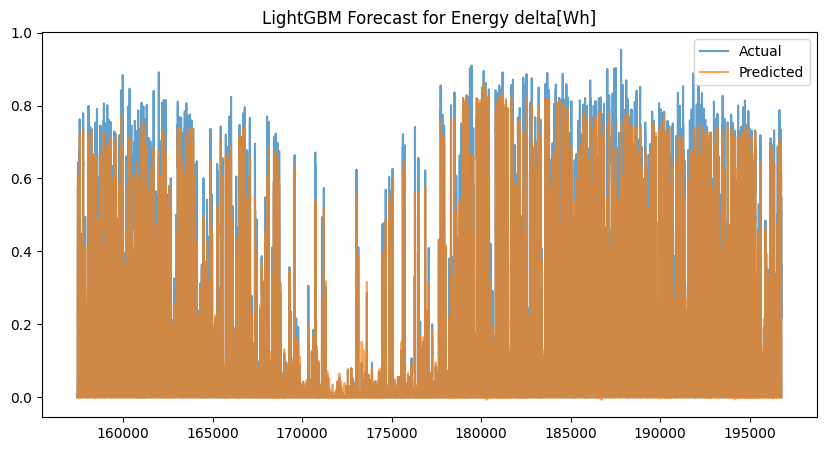

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, early_stopping, record_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 8. Train LightGBM with monitoring
model = LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

evals_result = {}  # Dictionary to store training history

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",  # Use RMSE for evaluation
    callbacks=[record_evaluation(evals_result)]  # ✅ Fix: Store training history
)

# 9. Predict
y_pred = model.predict(X_test)

# 10. Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# 11. Plot Training Curve (to check overfitting)
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE")  # ✅ Fix: "training" is now recorded
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE (LightGBM)")
plt.legend()
plt.show()

# 12. Plot Predictions vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("LightGBM Forecast for Energy delta[Wh]")
plt.legend()
plt.show()


### GAM

In [30]:
import pandas as pd
from pygam import LinearGAM, s

In [31]:

# Define GAM model with smooth terms for each feature
from pygam import LinearGAM, s

# Define GAM model with smooth terms for each feature
gam = LinearGAM(
    s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + 
    s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + 
    s(16)
).fit(X, y)

# Print model summary
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    217.2303
Link Function:                     IdentityLink Log Likelihood:                             -33339507.6234
Number of Samples:                       196776 AIC:                                         66679451.7073
                                                AICc:                                        66679452.1941
                                                GCV:                                                0.0029
                                                Scale:                                              0.0029
                                                Pseudo R-Squared:                                    0.934
Feature Function                  Lam

C:\Users\User\AppData\Local\Temp\ipykernel_17520\860962458.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test set
y_pred = gam.predict(X_test)

# Compute accuracy metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = (abs(y_test - y_pred) / y_test).mean() * 100

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 0.0275
MSE: 0.0030
RMSE: 0.0552
MAPE: inf%


### SVR

In [33]:
from sklearn.svm import SVR


In [34]:


# # 4. Define and Train SVR Model
# svr = SVR(kernel='rbf', C=10, epsilon=0.01)  # RBF kernel is good for nonlinear relationships
# svr.fit(X_train, y_train)

# # 5. Make Predictions
# y_pred = svr.predict(X_test)

# # 6. Evaluate the Model
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# mape = (abs(y_test - y_pred) / y_test).mean() * 100

# # 7. Print Performance Metrics
# print(f"MAE: {mae:.4f}")
# print(f"MSE: {mse:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"MAPE: {mape:.2f}%")

### CNN

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# 3. Normalize Data (CNNs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

# 4. Reshape Data for CNN [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/20


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4920/4920 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0079 - val_loss: 0.0044
Epoch 2/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 3/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 6/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 10/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 11/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 12/20
4920/4920 ━━━━━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_17520\1712566322.py:53: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100


### LSTM

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 3. Normalize Data (LSTMs work better with scaled inputs)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
# Convert y_train, y_test to NumPy arrays before reshaping
y_train_array = y_train.to_numpy().reshape(-1, 1)
y_test_array = y_test.to_numpy().reshape(-1, 1)

# Now you can scale them
y_train_scaled = scaler_y.fit_transform(y_train_array)
y_test_scaled = scaler_y.transform(y_test_array)

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
# y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
# y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# 4. Reshape Data for LSTM [Samples, Time Steps, Features]
TIME_STEPS = 10  # Number of previous time steps to use for prediction

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS)

# 5. Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEPS, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 6. Train the Model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_test_seq, y_test_seq), verbose=1)

# 7. Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 8. Evaluate the Model
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = root_mean_squared_error(y_test_seq, y_pred)
mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100

# 9. Print Performance Metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
 

Epoch 1/20


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4920/4920 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - loss: 0.0082 - val_loss: 0.0043
Epoch 2/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 10/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 11/20
4920/4920 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 12/20
4920/4920 ━━━━━━━━

C:\Users\User\AppData\Local\Temp\ipykernel_17520\669489113.py:60: RuntimeWarning: divide by zero encountered in divide
  mape = (abs(y_test_seq - y_pred) / y_test_seq).mean() * 100
